In [1]:
import pandas as pd
import pickle 
import seaborn as sns 
import matplotlib.pyplot as plt 
#mlflow ui --backend-store-uri sqlite:///mlflow.db
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.metrics import mean_squared_error

#

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment3")

<Experiment: artifact_location='/workspaces/mlops/02-experiment-tracking/mlruns/3', creation_time=1716426763664, experiment_id='3', last_update_time=1716426763664, lifecycle_stage='active', name='nyc-taxi-experiment3', tags={}>

In [3]:
df = pd.read_parquet(r'./data/green_tripdata_2021-01.parquet')


In [4]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/workspaces/mlops/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

/tmp/ipykernel_31776/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_31776/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


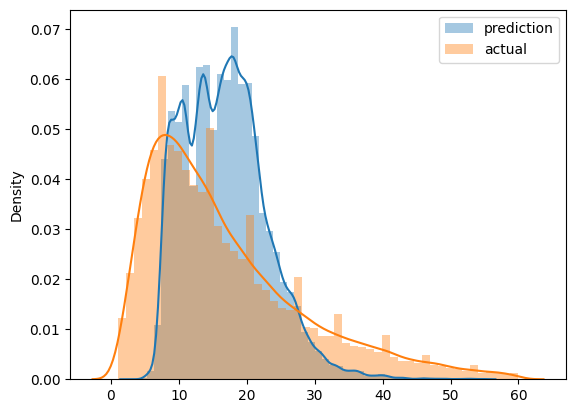

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [9]:

len(df_train), len(df_val)

(73908, 61921)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/workspaces/mlops/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715209663881

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "mustafa")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha=0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

/workspaces/mlops/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from hyperopt.pyll import scope



In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [20]:


with mlflow.start_run():
    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1_000,
        evals=[(valid,'validaiton')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


/workspaces/mlops/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:38:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validaiton-rmse:11.44482
[1]	validaiton-rmse:10.77202
[2]	validaiton-rmse:10.18363
[3]	validaiton-rmse:9.67396
[4]	validaiton-rmse:9.23166
[5]	validaiton-rmse:8.84808
[6]	validaiton-rmse:8.51883
[7]	validaiton-rmse:8.23597
[8]	validaiton-rmse:7.99320
[9]	validaiton-rmse:7.78709
[10]	validaiton-rmse:7.61022
[11]	validaiton-rmse:7.45952
[12]	validaiton-rmse:7.33049
[13]	validaiton-rmse:7.22098
[14]	validaiton-rmse:7.12713
[15]	validaiton-rmse:7.04752
[16]	validaiton-rmse:6.98005
[17]	validaiton-rmse:6.92232
[18]	validaiton-rmse:6.87112
[19]	validaiton-rmse:6.82740
[20]	validaiton-rmse:6.78995
[21]	validaiton-rmse:6.75792
[22]	validaiton-rmse:6.72994
[23]	validaiton-rmse:6.70547
[24]	validaiton-rmse:6.68390
[25]	validaiton-rmse:6.66421
[26]	validaiton-rmse:6.64806
[27]	validaiton-rmse:6.63280
[28]	validaiton-rmse:6.61924
[29]	validaiton-rmse:6.60773
[30]	validaiton-rmse:6.59777
[31]	validaiton-rmse:6.58875
[32]	validaiton-rmse:6.58107
[33]	validaiton-rmse:6.57217
[34]	validaiton-rmse:

/workspaces/mlops/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/workspaces/mlops/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:41:29] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


### Load Model

In [21]:
logged_model = 'runs:/8020b148c609437899fb367a0a547a08/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

/workspaces/mlops/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [03:07:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [22]:
y_pred = loaded_model.predict(valid)

/workspaces/mlops/venv/lib/python3.9/site-packages/xgboost/data.py:1037: UserWarning: Unknown data type: <class 'xgboost.core.DMatrix'>, trying to convert it to csr_matrix
  warnings.warn(


TypeError: Not supported type for data.<class 'xgboost.core.DMatrix'>

In [2]:
x = {'a': 1, 'b': 2}
print(**x)

TypeError: 'a' is an invalid keyword argument for print()